# BMI Topography to GRASS GIS to Landlab model grid

### Created By: Caitlin Haedrich and Shelby Ahrendt, May 2024
_____________________________________________________________________________________________

### About this notebook

Have you ever wanted to load elevation data from online, reproject this to an appropriate model coordinate system, maybe use some GRASS GIS tools, and then use this data as the basis of your Landlab model grid? Then look no further!

This notebook:
1. imports SRTM elevation data into a [GRASS](https://grass.osgeo.org/) project using [bmi_topography](https://bmi-topography.readthedocs.io/en/latest/). 
2. Offers opportunities for advanced GRASS calculations using imported elevation data.
3. Loads a GRASS layer (the STRM elevaton data imported earlier) as a landlab RasterModelGrid for future modeling endeavors.
4. Exports elevation data from GRASS GIS as a .tif file

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from bmi_topography import Topography
import subprocess
import sys

We are going to import the GRASS GIS Python API (`grass.script`) and the GRASS GIS Jupyter package (`grass.jupyter`), but first, we need to find the path to those packages using the `--config python_path` command. This command is slightly different for each operating system.

We use `subprocess.check_output` to find the path and `sys.path.append` to add it to the path.

In [2]:
# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

And now we can import the GRASS python packages!

In [3]:
import grass.script as gs
import grass.jupyter as gj

## Create GRASS Project
We will create a GRASS project that will nest under a new folder `colorado`. You should see this folder appear in your `bmi-topography-grass` directory. This is where all the special GRASS files will be stored. GRASS GIS has its own native data format so this folder will contain the data and information about the computational extent and resolution.
* Note: here we have pre-set the coordinate system to [EPSG:32613](https://epsg.io/32613) (UTM Zone 13) becuase we know we want to work in the Colorado region. This forces all future data loaded into GRASS to be reprojected into UTM13. If you are planning to download topography for a different region, you can set an appropriate coordinate system here. The UTM CRS often works well with Landlab grids, because it has native x,y dimensions of meters, but you can choose whatever works best for your purpose.

In [4]:
!grass -e -c EPSG:32613 $HOME/bmi-topography-grass/colorado

Creating new GRASS GIS location <colorado>...


## Start GRASS Session
We will now initiate a GRASS session using the [GRASS jupyter](https://grass.osgeo.org/grass83/manuals/libpython/grass.jupyter.html) package.

In [5]:
# Start GRASS Session
gj.init("./colorado/PERMANENT/");

Let's check our coordinate system and grid region:

In [6]:
print(gs.read_command("g.region", flags="p"))

projection: 1 (UTM)
zone:       13
datum:      wgs84
ellipsoid:  wgs84
north:      1
south:      0
west:       0
east:       1
nsres:      1
ewres:      1
rows:       1
cols:       1
cells:      1



Here, we can check that we're using UTM zone 13 (which covers Colorado) and that our computational extent is only 1 meter by 1 meter. We'll change the region after we import some data with [bmi_topography](https://bmi-topography.readthedocs.io/en/latest/).

## Fetch Data with `bmi_topography`
Next, we load data with [bmi_topography](https://bmi-topography.readthedocs.io/en/latest/). Note that there is a wide variety of data sources available--here, we load `SRTMGL3` data. By default, this data is queried via WGS84 crs. We thus specify central `north`, `south`, `east`, and `west`, coordinates in degrees offset by a `width` value. This loads data from the [Saint Vrain Drainage](https://maps.app.goo.gl/Xx5ApLcXQMxu3jzX7) near Lyons, CO. If you are interested in a different region, input your coordinates here.
* Note: bmi_topography loads data via [OpenTopography](https://opentopography.org/) which requires API access. You may see a warning that says you are given access to this via a demo key.

In [7]:
width = 0.05
dem = Topography(
    north=40.16 + width,
    south=40.14 - width,
    east=-105.4 + width,
    west=-105.5 - width,
    dem_type="SRTMGL3",
    output_format="GTiff"
)

fname = dem.fetch()

/opt/tljh/user/envs/csdms/lib/python3.11/site-packages/bmi_topography/api_key.py:49: UserWarning: You are using a demo key to fetch data from OpenTopography, functionality will be limited. See https://bmi-topography.readthedocs.io/en/latest/#api-key for more information.
  warnings.warn(


## Import DEM into GRASS

Here we create a layer called `dem` and specify the input data to be `fname` which directs to a temporary .tif file loaded by [bmi_topography](https://bmi-topography.readthedocs.io/en/latest/). We force it to a resolution of 50m, but you can tailor this based upon your source data or computational needs. (e.g. SRTMGL3 data has a native resolution of 30m)

In [8]:
gs.run_command("r.import", input=fname, output="dem", resolution="value", resolution_value=50)

Now let's set the computatonal region to the extent and resolution of the layer 'dem' that we just imported.

In [9]:
# Change computational region to DEM
gs.run_command("g.region", raster="dem", flags="p")

projection: 1 (UTM)
zone:       13
datum:      wgs84
ellipsoid:  wgs84
north:      4451250
south:      4437850
west:       453100
east:       470150
nsres:      50
ewres:      50
rows:       268
cols:       341
cells:      91388


### Plot GRASS raster

Let's visualize the topography we just imported!

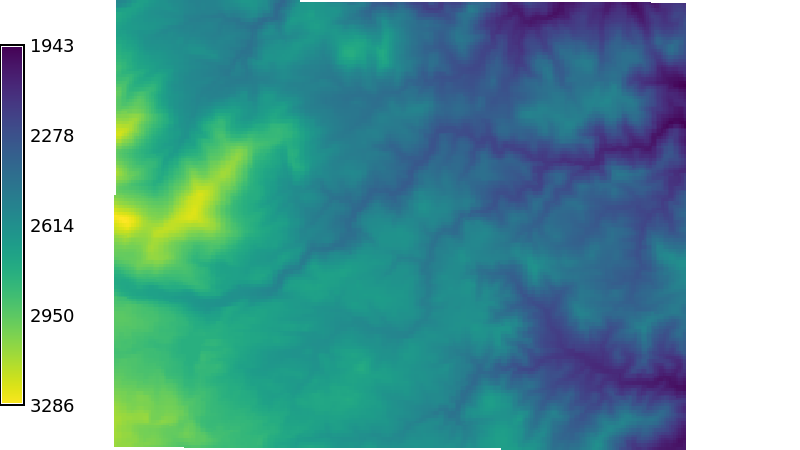

In [10]:
img = gj.Map(width = 800, height = 450)
img.d_rast(map="dem")
img.d_legend(raster="dem", at=(10,90,0,3), bgcolor="white")
img.show()

## Insert your GRASS analysis here...
Now you can work with this topography using any GRASS functions here!

## Dealing with Nulls

Notice the edges of this terrain have null values after the reprojection into UTM 13. For some workflows, this may not be an issue. For others, we may want to replace the nulls with a value.

Here we use [`r.null`](https://grass.osgeo.org/grass83/manuals/r.null.html) to replace the nulls with -9999.

In [11]:
!r.null map="dem" null=-9999

   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100


## Some Export Options

You may want to export this elevation data (or any of your other GRASS calculations) as a GeoTiff, or you may want to add this data to a Landlab [RasterModelGrid](https://landlab.readthedocs.io/en/latest/reference/grid/raster.html) for model simulations.

### Option 1: Load into a Landlab RasterGridModel

In [13]:
# Additional Imports
import grass.script.array as garray
from landlab import RasterModelGrid, imshow_grid

We're going to use info about the raster to determine the spacing and shape of the RasterModelGrid. `raster_info` returns a dictionary where we can get the resolution and dimensions of the raster.

In [14]:
raster_info = gs.raster_info(map="dem")
raster_info

{'north': 4451250.0,
 'south': 4437850.0,
 'east': 470150.0,
 'west': 453100.0,
 'nsres': 50.0,
 'ewres': 50.0,
 'rows': '268',
 'cols': '341',
 'cells': '91388',
 'datatype': 'CELL',
 'ncats': '3286',
 'min': -9999.0,
 'max': 3286.0,
 'map': 'dem',
 'maptype': 'raster',
 'mapset': 'PERMANENT',
 'location': 'colorado',
 'database': '/home/jupyter-chaedri@ncsu.edu/bmi-topography-grass',
 'date': '"Thu May 30 20:33:36 2024"',
 'creator': '"jupyter-chaedri@ncsu.edu"',
 'title': '""',
 'timestamp': '"none"',
 'units': '"none"',
 'vdatum': '"none"',
 'semantic_label': '"none"',
 'source1': '""',
 'source2': '""',
 'description': '"generated by r.proj"',
 'comments': '"r.proj --quiet location="tmp_r_import_location_ip_172_31_5_210_68055\\" mapset="PERMANENT" input="dem" method="nearest" memory=300 resolut\\ion=50.0"'}

RasterModelGrid has one xy_spacing value so we need to make sure that the east-west resolution and north-south resolution are equal.

In [15]:
# Make sure the east and west resolution is the same (since RasterModelGrid has one xy_spacing value)
assert raster_info['ewres']==raster_info['nsres']

Then we can get the spacing and shape for our RasterModelGrid.

In [16]:
spacing = raster_info['nsres']
shape = (int(raster_info['rows']), int(raster_info['cols']))

Now that we have the spacing and shape of the array, we'll get the raster as an array and then flip and flatten to match the RasterModelGrid pattern.

In [17]:
# Get GRASS Elevation Raster as np array
elev = garray.array("dem")

# Flip and flatten to match RasterModelGrid node pattern
flip = np.flip(elev, 0)
flat_elev = flip.flatten()

Finally, make the grid object and assign node values!

In [18]:
# Make our RasterModelGrid using info from GRASS
grid = RasterModelGrid(shape, xy_spacing=spacing)
grid.at_node["topographic__elevation"] = flat_elev

/opt/tljh/user/envs/csdms/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


Plot the Landlab grid:

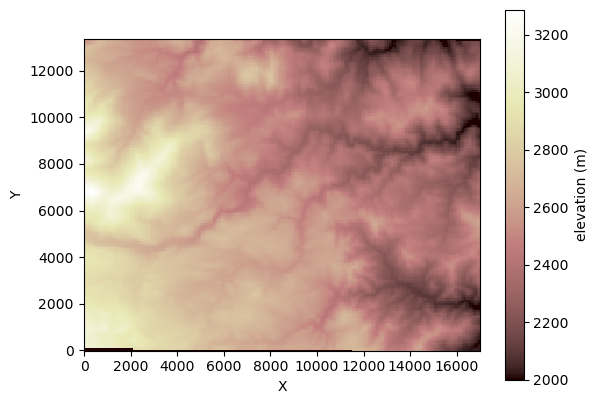

In [19]:
imshow_grid(grid,'topographic__elevation', vmin=2000, var_name='elevation (m)')

### Option 2: Export to GeoTiff

We can also export raster data from GRASS GIS with [`r.out.gdal`](https://grass.osgeo.org/grass83/manuals/r.out.gdal.html).

In [12]:
gs.run_command("r.out.gdal", input="dem", output="dem.tif")

Check your file browser panel and you should see a new file!